In [16]:
import pickle
import os

# Define the path for the model
MODEL_PATH = './model/best_model.pkl'

# Function to load the previous best model if it exists
def load_previous_model():
    if os.path.exists(MODEL_PATH):
        with open(MODEL_PATH, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {MODEL_PATH}")
        return model
    return None

def save_model(model):
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved in {MODEL_PATH}")

## ÁRBOLES DE DECISIÓN – CLASIFICACIÓN BAYESIANA

## PUNTO 1

## **Descripción de los datos**
El conjunto de datos contiene información sobre el ausentismo laboral de empleados. Cada fila representa un registro de ausentismo con varias características (*features*) que pueden influir en la cantidad de horas de ausencia. Algunas de las principales características son:

- **Month of absence**: Mes en el que ocurrió la ausencia.
- **Day of the week**: Día de la semana en que ocurrió la ausencia.
- **Seasons**: Estación del año en que ocurrió la ausencia.
- **Transportation expense**: Gastos de transporte del empleado.
- **Distance from Residence to Work**: Distancia entre el hogar del empleado y el trabajo.
- **Service time**: Años de servicio del empleado.
- **Age**: Edad del empleado.
- **Work load Average/day**: Carga de trabajo promedio por día.
- **Disciplinary failure**: Indica si el empleado ha tenido fallas disciplinarias.
- **Education**: Nivel educativo del empleado.
- **Social drinker**: Indica si el empleado consume alcohol de forma social.
- **Social smoker**: Indica si el empleado fuma socialmente.
- **Body mass index (BMI)**: Índice de masa corporal del empleado.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)
df = pd.read_excel('Absenteeism_at_work.xls')
df.rename(columns={'Work load Average/day ':'Work load Average/day'}, inplace=True)
df.head()

ID  Reason for absence  Month of absence  Day of the week  Seasons  \
0  11                  26                 7                3        1   
1  36                   0                 7                3        1   
2   3                  23                 7                4        1   
3   7                   7                 7                5        1   
4  11                  23                 7                5        1   

   Transportation expense  Distance from Residence to Work  Service time  Age  \
0                     289                               36            13   33   
1                     118                               13            18   50   
2                     179                               51            18   38   
3                     279                                5            14   39   
4                     289                               36            13   33   

   Work load Average/day  Hit target  Disciplinary failure  Education  Son  \
0                 239554          97                     0          1    2   
1                 239554          97                     1          1    1   
2                 239554          97                     0          1    0   
3                 239554          97                     0          1    2   
4                 239554          97                     0          1    2   

   Social drinker  Social smoker  Pet  Weight  Height  Body mass index  \
0               1              0    1      90     172               30   
1               1              0    0      98     178               31   
2               1              0    0      89     170               31   
3               1              1    0      68     168               24   
4               1              0    1      90     172               30   

   Absenteeism time in hours  
0                          4  
1                          0  
2                          2  
3                          4  
4                          2

## **Contextualización del problema**
El objetivo del análisis es predecir la cantidad de tiempo que un empleado estará ausente basado en sus características personales y laborales. Para ello, se definió una clasificación basada en la columna **"Absenteeism time in hours"**, que es la variable objetivo (*target*):

1. **0** → No faltó.
2. **1** → Menos de un día (< 8 horas).
3. **2** → Menos de una semana (< 40 horas).
4. **3** → Más de una semana (> 40 horas).

## **Preprocesamiento realizado**
1. **Corrección de nombres de columnas**: Se eliminó el espacio extra en `"Work load Average/day "`.
2. **Creación de una nueva variable categórica**: Se transformó `"Absenteeism time in hours"` en la nueva columna `"clasificacion_abstinencia"`, que agrupa los valores en categorías más manejables.
3. **Eliminación de columnas irrelevantes**: Se eliminaron `"ID"`, `"Reason for absence"` y `"Absenteeism time in hours"`, ya que no aportan información relevante o son redundantes.

In [42]:
"""
no falto                0
menos de un dia         <8
menos de una semana     <40
mas de una semana       >40
"""

df["clasificacion_abstinencia"] = df["Absenteeism time in hours"].apply(
    lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 40 else 3
)
df = df.drop(
    columns=["ID", "Reason for absence", "Absenteeism time in hours"], errors="ignore"
)
df["clasificacion_abstinencia"].value_counts()

clasificacion_abstinencia
1    425
2    249
0     44
3     22
Name: count, dtype: int64

## **Análisis de la distribución de la variable objetivo**
El gráfico de barras muestra la cantidad de registros en cada una de las categorías de ausentismo. Se puede observar que la mayoría de los empleados faltan por menos de un día o no faltan en absoluto, mientras que los casos de ausentismo prolongado son menos frecuentes.

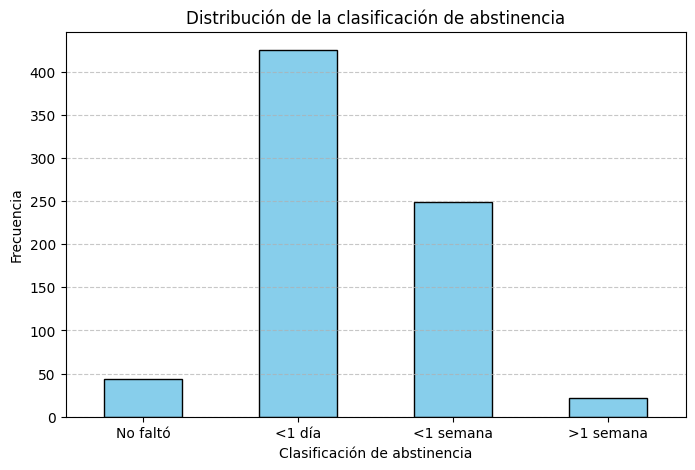

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('Absenteeism_at_work.xls')

df.rename(columns={'Work load Average/day ': 'Work load Average/day'}, inplace=True)

df["clasificacion_abstinencia"] = df["Absenteeism time in hours"].apply(
    lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 40 else 3
)

df = df.drop(columns=["ID", "Reason for absence", "Absenteeism time in hours"], errors="ignore")

clasificacion_counts = df["clasificacion_abstinencia"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
clasificacion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xticks(ticks=[0, 1, 2, 3], labels=["No faltó", "<1 día", "<1 semana", ">1 semana"], rotation=0)
plt.xlabel("Clasificación de abstinencia")
plt.ylabel("Frecuencia")
plt.title("Distribución de la clasificación de abstinencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analisis

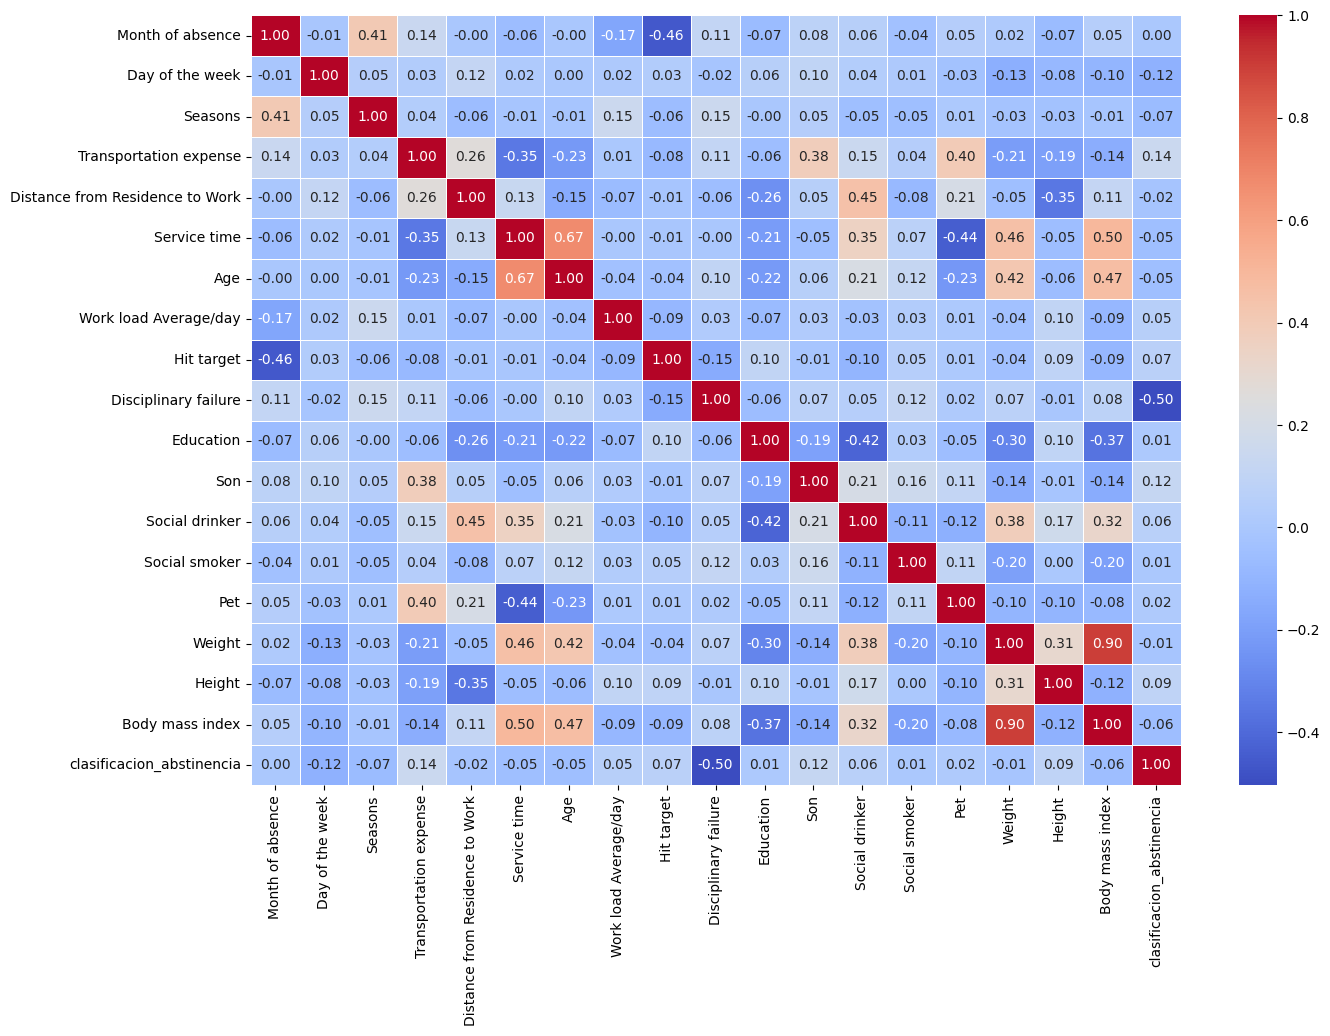

In [19]:
import seaborn as sns
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5);

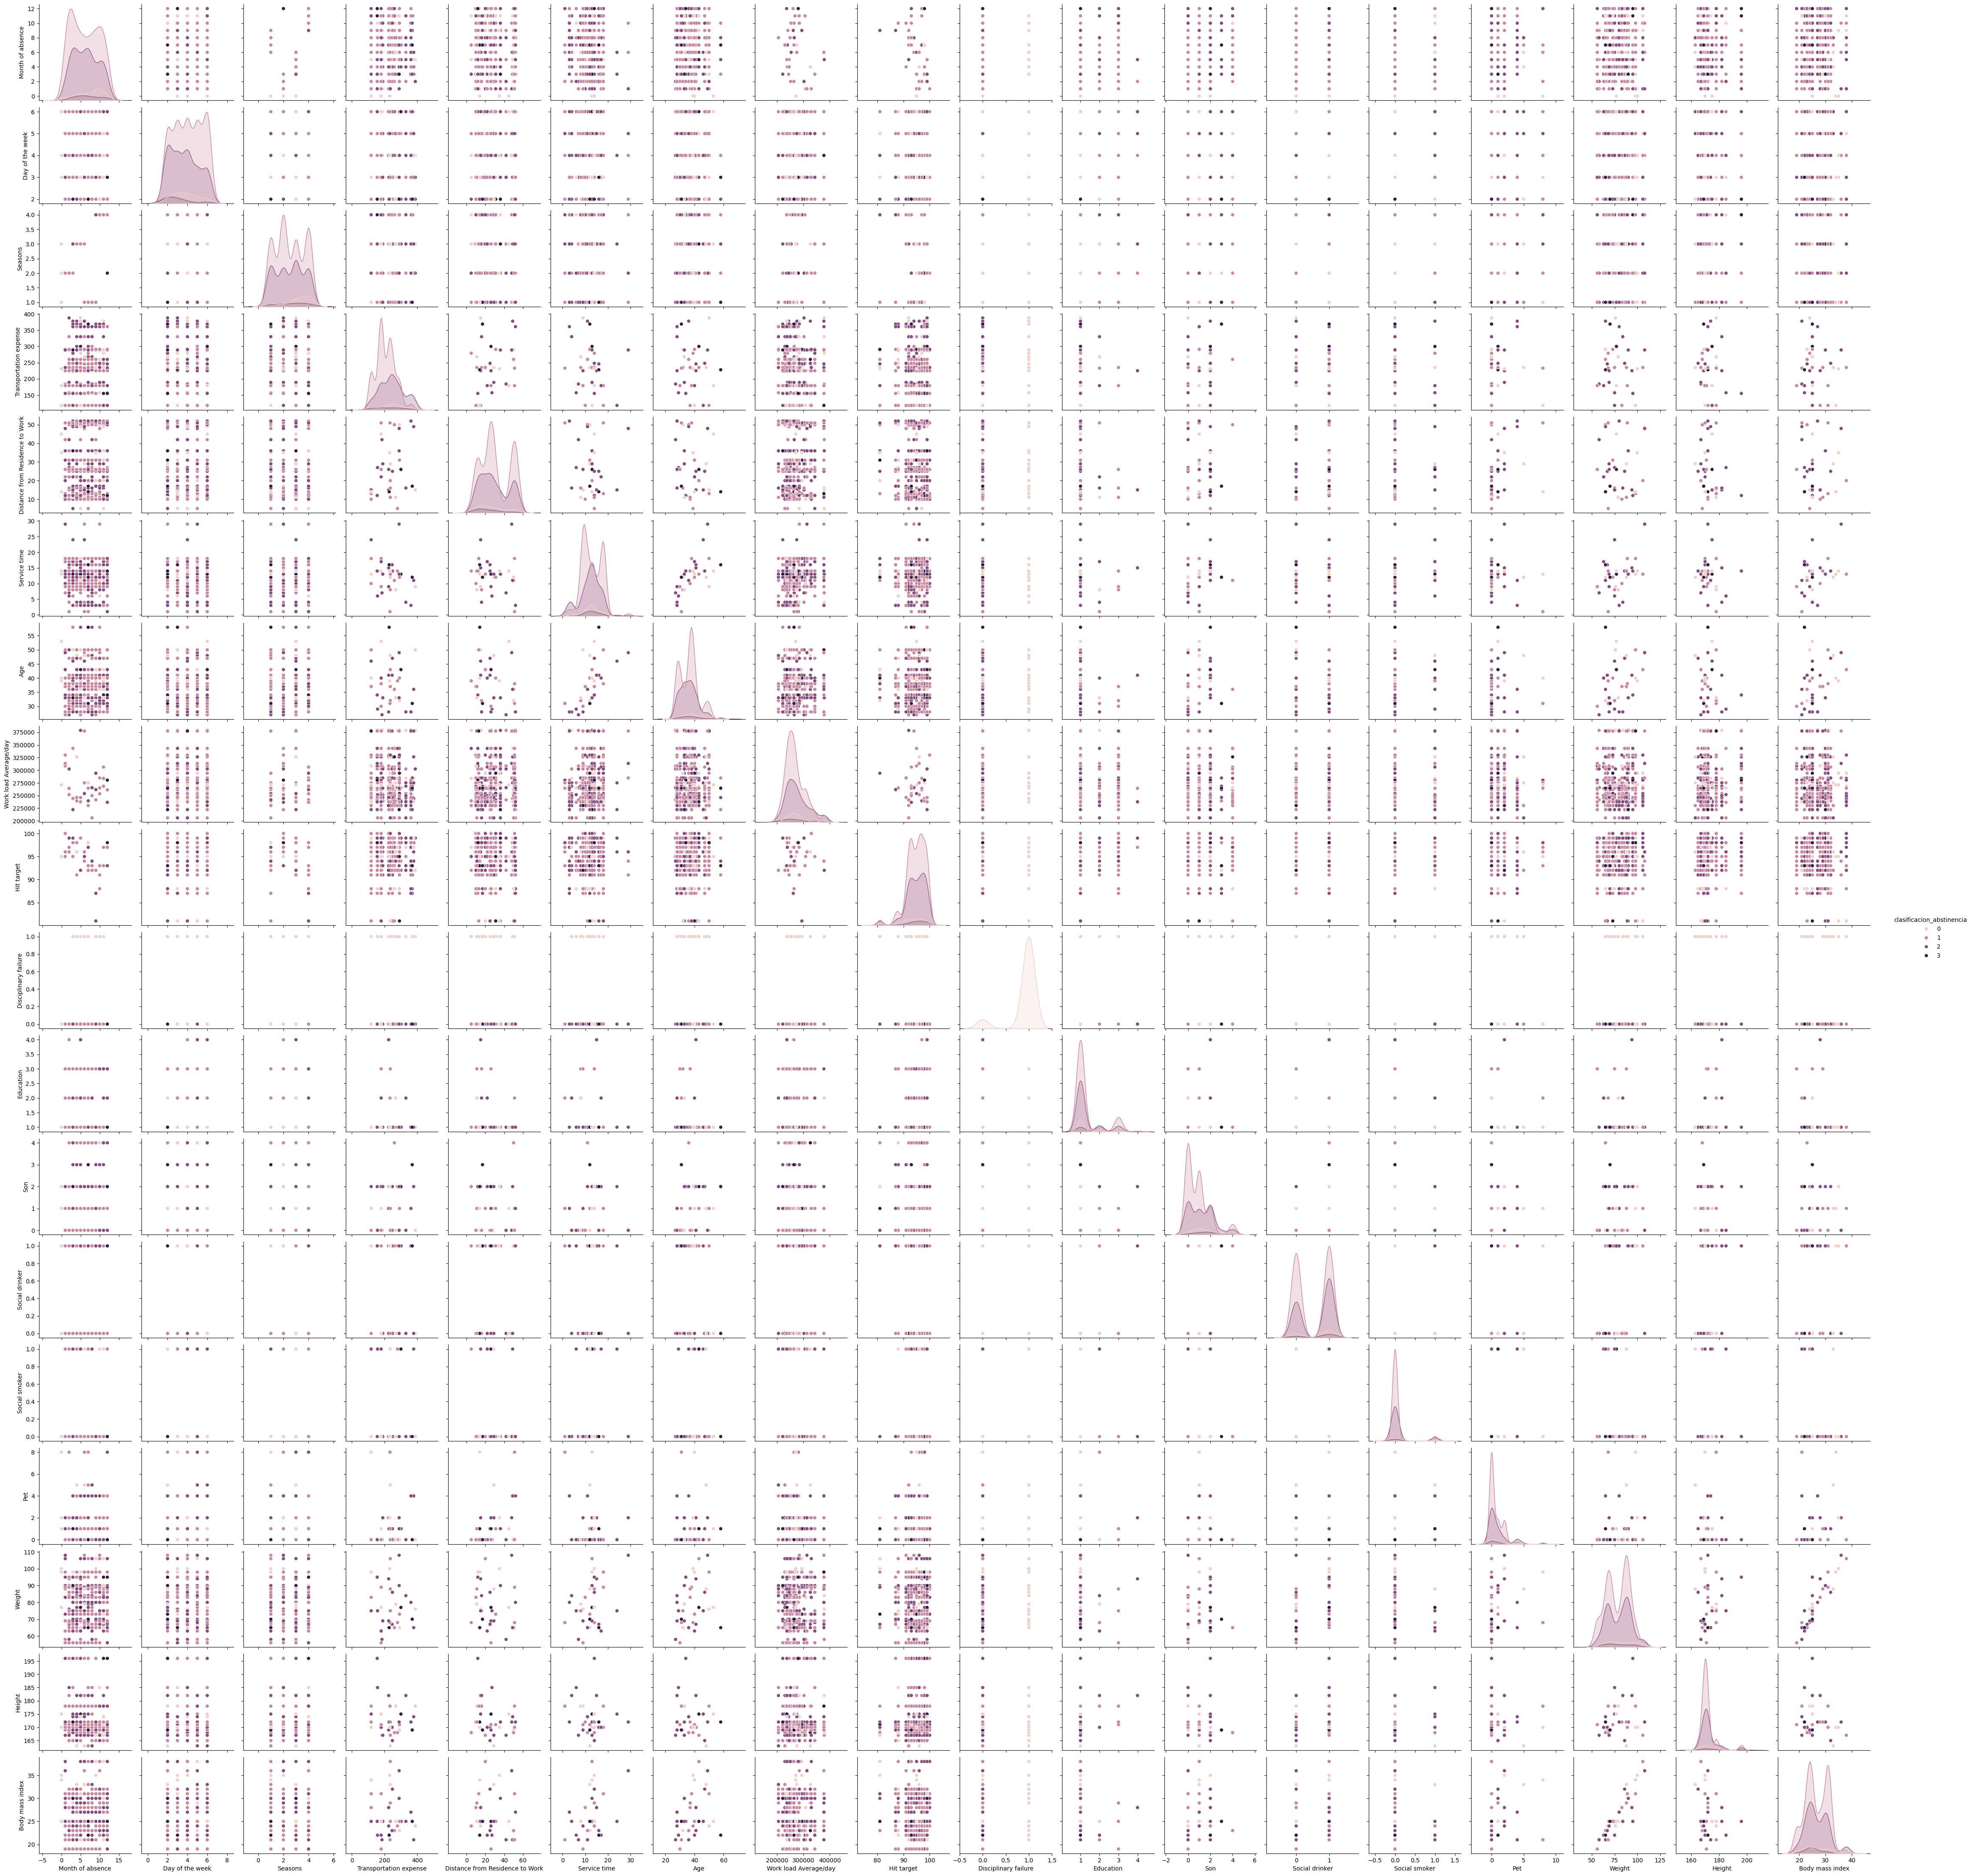

In [20]:
sns.pairplot(df, hue="clasificacion_abstinencia");

### **Diferentes profundidades del árbol**

In [21]:
from sklearn.model_selection import KFold
from sklearn import tree

cv = KFold(n_splits=20) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(df))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
  # X = df.drop(columns=["clasificacion_abstinencia"])
  # y = df["clasificacion_abstinencia"]

  fold_accuracy = []
  tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
  
  for train_fold, valid_fold in cv.split(df):
    f_train = df.loc[train_fold]
    f_valid = df.loc[valid_fold]

    model = tree_model.fit(X = f_train.drop(columns=["clasificacion_abstinencia"]),
                           y = f_train["clasificacion_abstinencia"])
    valid_acc = model.score(X = f_valid.drop(columns=["clasificacion_abstinencia"]),
                            y = f_valid["clasificacion_abstinencia"])
    fold_accuracy.append(valid_acc)
  
  avg = sum(fold_accuracy)/len(fold_accuracy)
  accuracies.append(avg)

# Mostramos los resultados obtenidos
dataframe = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
dataframe = dataframe[["Max Depth", "Average Accuracy"]]
print(dataframe.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.509459
         2          0.206757
         3          0.410811
         4          0.475676
         5          0.482432
         6          0.497297
         7          0.532432
         8          0.556757
         9          0.591892
        10          0.602703
        11          0.602703
        12          0.598649
        13          0.600000
        14          0.602703
        15          0.601351
        16          0.597297
        17          0.597297
        18          0.598649
        19          0.598649


## PUNTO 2

### DT Entrenamiento

In [22]:
from joblib import Memory

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.tree import DecisionTreeClassifier

# Cache
memory = Memory(location="./pipeline_cache", verbose=0)

pipeline = Pipeline(
    steps=[
        ("feature_selection", SelectKBest(score_func=f_classif)),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ],
    memory=memory
)

## **Justificación del nodo raíz y nodos hijo**
- El **nodo raíz** del árbol de decisión se selecciona en función de la característica que maximiza la ganancia de información (para Entropía) o minimiza la impureza (para Gini).
- Se analizaron las **importancias de las características**, y se puede observar cuáles son las variables más relevantes para la clasificación de la ausencia.
- Las características con mayor importancia en ambos métodos son claves para entender qué factores influyen más en el ausentismo.


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = df.drop(columns=["clasificacion_abstinencia"])
y = df["clasificacion_abstinencia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [47]:
param_grid = {
"feature_selection__k": range(1, 10),
"feature_selection__score_func": [f_classif, chi2],
"classifier__criterion": ["gini", "entropy"],
"classifier__max_depth": range(1, 10),
"classifier__min_samples_split": range(2, 10),
"classifier__min_samples_leaf": range(1, 10),
"classifier__class_weight": ["balanced", None]
}

current_model = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=10, scoring="balanced_accuracy")

current_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
current_model = load_previous_model() or current_model

Model loaded from ./model/best_model.pkl


C:\Users\Usser\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SelectKBest from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Usser\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Usser\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6

**Entropía** es un mejor criterio en este caso, ya que logra una mejor separación de las clases y obtiene mayor precisión.

In [ ]:
current_model.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'feature_selection__k': 4,
 'feature_selection__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

In [ ]:
best_selector = current_model.best_estimator_.named_steps["feature_selection"]
best_classifier = current_model.best_estimator_.named_steps["classifier"]

In [ ]:
for feature, score in zip(
    X.columns[best_selector.get_support()],
    best_selector.scores_[best_selector.get_support()],
):
    print(f"{feature}: {score:.2f}")

Day of the week: 7.23
Transportation expense: 13.80
Disciplinary failure: 3042.80
Son: 8.85


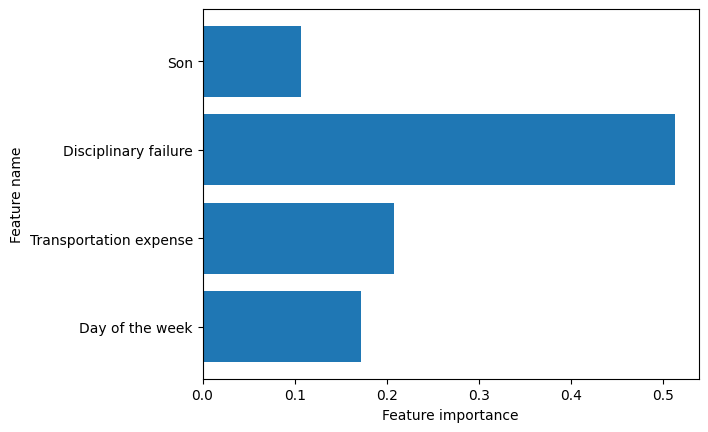

In [ ]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

feature_names = X.columns[best_selector.get_support()]
plot_feature_importances(best_classifier, feature_names)

## Plot tree

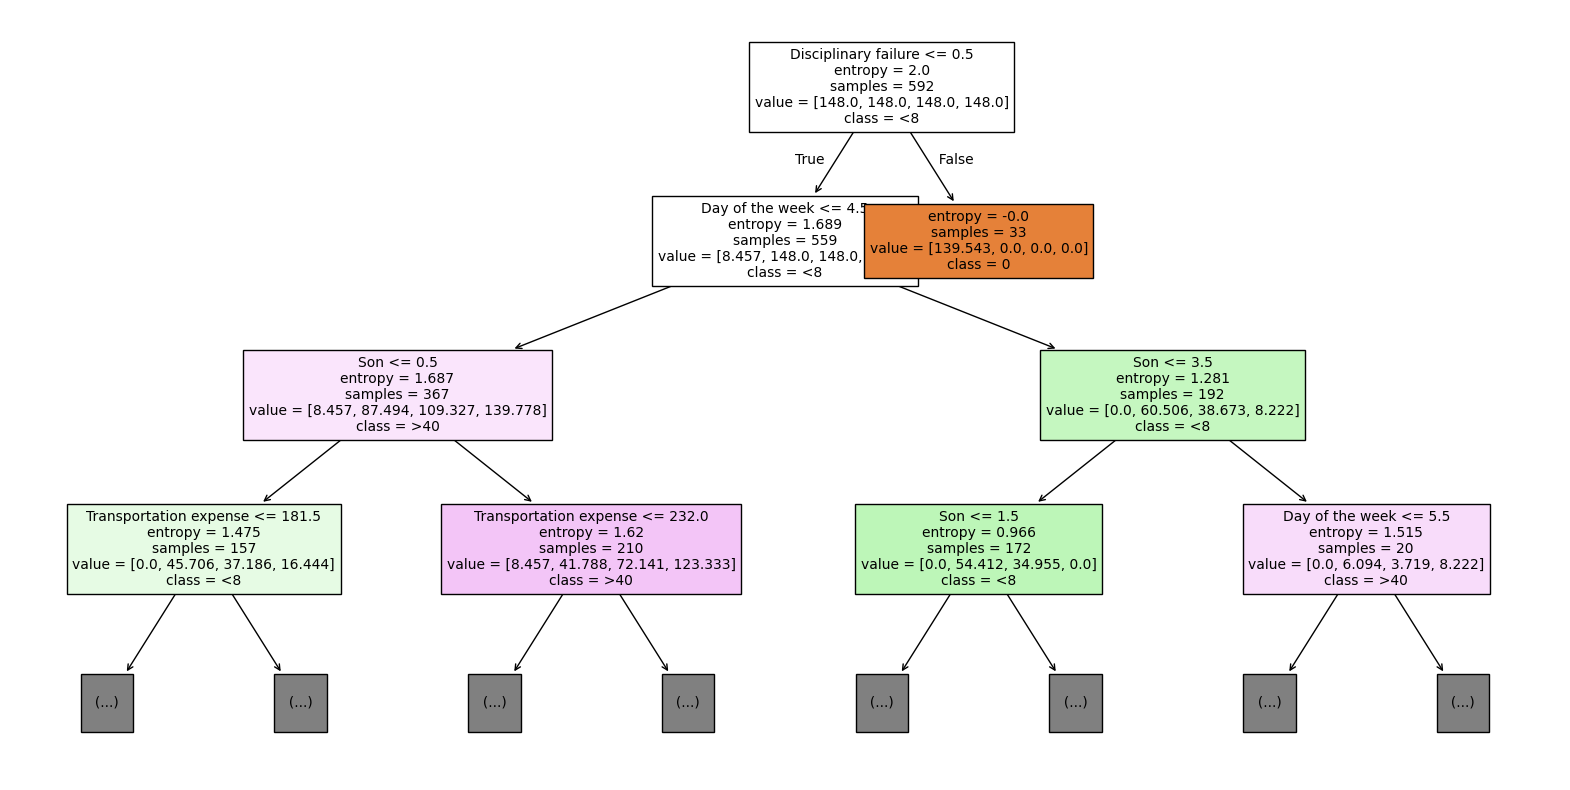

In [30]:
from sklearn import tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_classifier, feature_names=feature_names, filled=True, fontsize=10, max_depth=3, class_names=["0", "<8", "<40", ">40"]);

In [31]:
from supertree import SuperTree

super_tree = SuperTree(
    model=best_classifier,
    feature_data=X_train[feature_names],
    target_data=y.values,
    feature_names=feature_names.tolist(),  # Use list instead of Index
    target_names=["0", "1", "2", "3"],
)
super_tree.show_tree(start_depth=3)

## Score

In [32]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Accuracy of Decision:")
print(f"Accuracy of Decision Tree classifier on test set {accuracy_score(y_test, current_model.predict(X_test)):.2f}")
print(f"Accuracy of Decision Tree classifier on training set {accuracy_score(y_train, current_model.predict(X_train)):.2f}")

print("\nBalanced accuracy:")
print(f"Balanced accuracy of Decision Tree classifier on test set {balanced_accuracy_score(y_test, current_model.predict(X_test)):.2f}")
print(f"Balanced accuracy of Decision Tree classifier on training set {balanced_accuracy_score(y_train, current_model.predict(X_train)):.2f}")

Accuracy of Decision:
Accuracy of Decision Tree classifier on test set 0.62
Accuracy of Decision Tree classifier on training set 0.67

Balanced accuracy:
Balanced accuracy of Decision Tree classifier on test set 0.62
Balanced accuracy of Decision Tree classifier on training set 0.80


In [33]:
# Calcule la métrica de exactitud, precisión, recall y F1-score tanto  para  el entrenamiento como para la validación.
from sklearn.metrics import classification_report
print("Classification report test:")
print(classification_report(y_test, current_model.predict(X_test), target_names=["0", "<8", "<40", ">40"]))
print("Classification report entrenamiento:")
print(classification_report(y_train, current_model.predict(X_train), target_names=["0", "<8", "<40", ">40"]))

Classification report test:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
          <8       0.75      0.64      0.69        85
         <40       0.71      0.58      0.64        50
         >40       0.08      0.50      0.14         4

    accuracy                           0.62       148
   macro avg       0.56      0.62      0.55       148
weighted avg       0.71      0.62      0.66       148

Classification report entrenamiento:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        35
          <8       0.85      0.65      0.74       340
         <40       0.69      0.62      0.65       199
         >40       0.15      0.94      0.26        18

    accuracy                           0.67       592
   macro avg       0.64      0.80      0.64       592
weighted avg       0.78      0.67      0.70       592



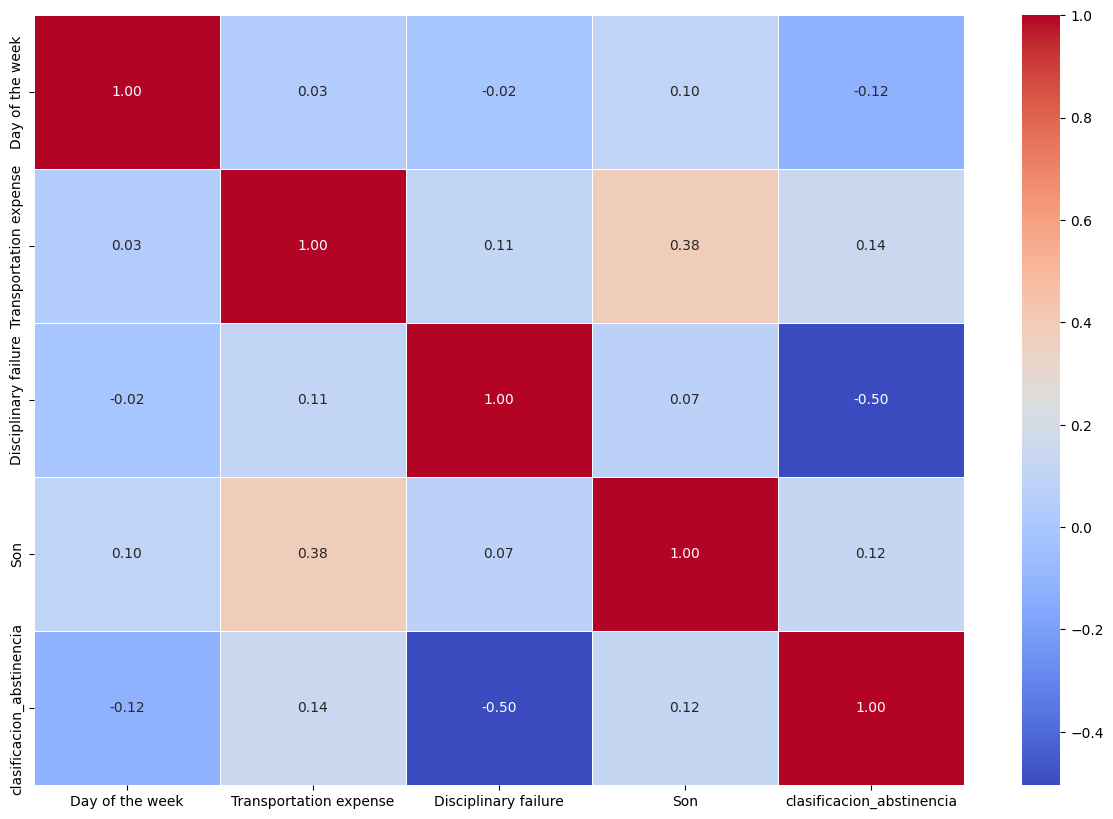

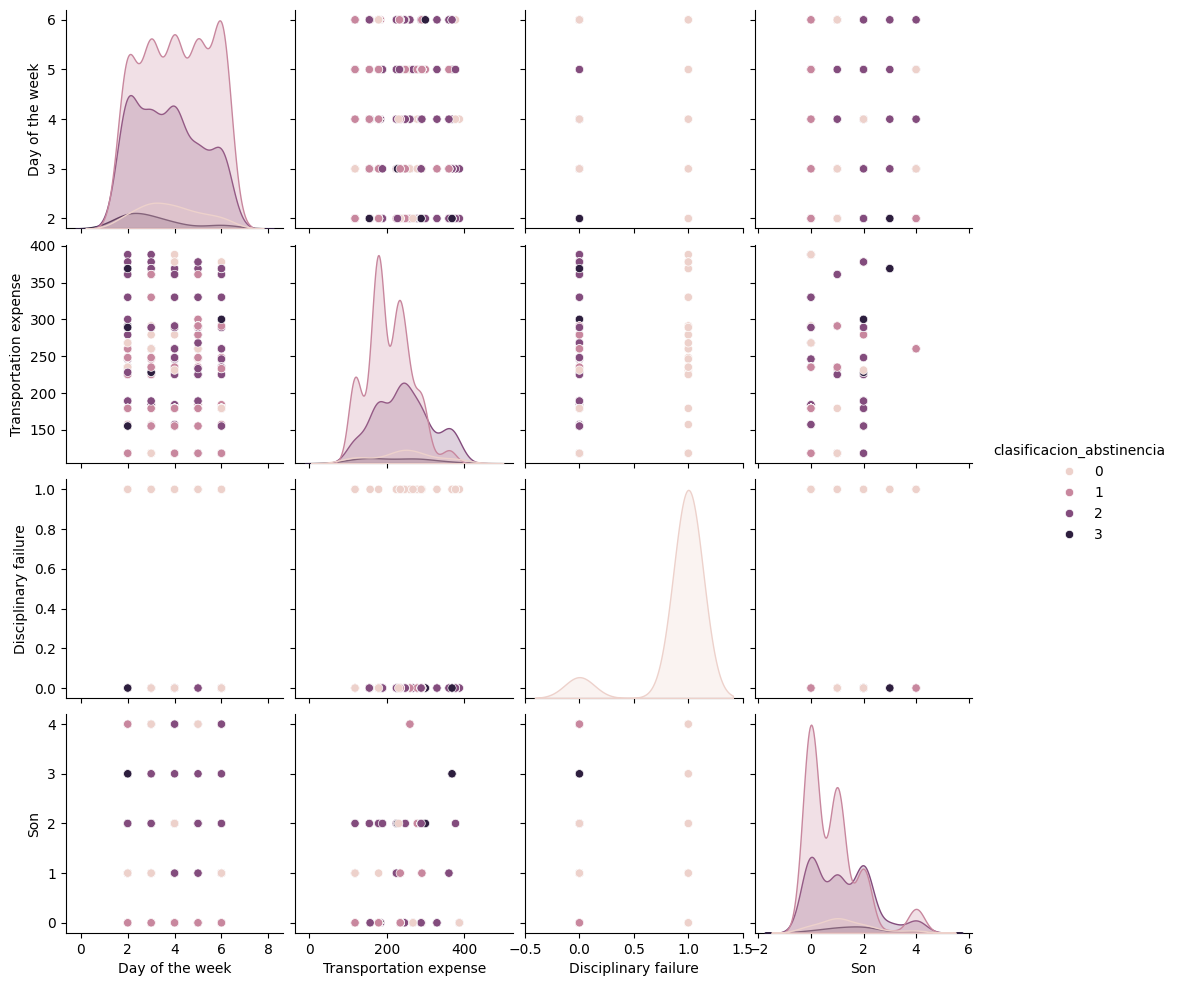

In [34]:
import seaborn as sns
df_selected_features = pd.DataFrame(X[X.columns[best_selector.get_support()]])
df_selected_features["clasificacion_abstinencia"] = y
plt.figure(figsize=(15, 10))
correlation_matrix = df_selected_features.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
sns.pairplot(df_selected_features, hue="clasificacion_abstinencia");

## matrix de confusion

Casos de test: 148
Casos de entrenamiento: 592


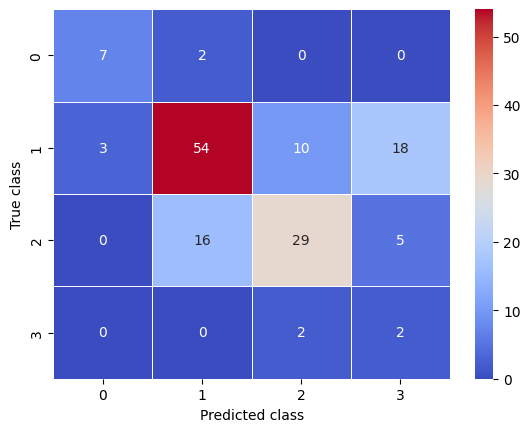

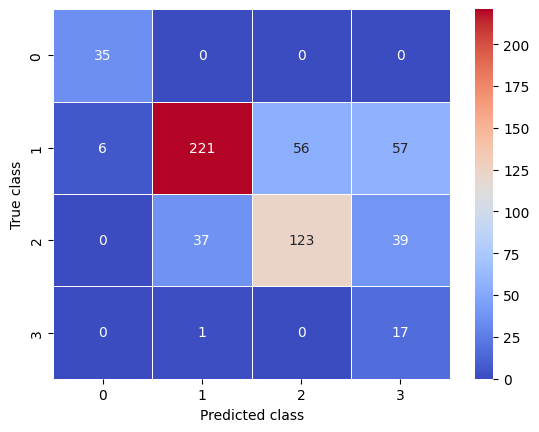

In [35]:
# matrix de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns

print(f"Casos de test: {y_test.size}")
conf_matrix = confusion_matrix(y_test, current_model.predict(X_test))
plt.figure()

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Predicted class")
plt.ylabel("True class")

print(f"Casos de entrenamiento: {y_train.size}")
conf_matrix = confusion_matrix(y_train, current_model.predict(X_train))
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Predicted class")
plt.ylabel("True class");

In [36]:
y_pred = current_model.predict(X_test)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred
})

mask = (results_df['Real'] == 1) & (results_df['Predicho'] == 0)
cases = X_test[mask]
cases

Month of absence  Day of the week  Seasons  Transportation expense  \
306                10                3        4                     118   
403                 3                3        3                     118   
366                 1                2        2                     118   

     Distance from Residence to Work  Service time  Age  \
306                               13            18   50   
403                               13            18   50   
366                               13            18   50   

     Work load Average/day  Hit target  Disciplinary failure  Education  Son  \
306                 265017          88                     0          1    1   
403                 244387          98                     0          1    1   
366                 330061         100                     0          1    1   

     Social drinker  Social smoker  Pet  Weight  Height  Body mass index  
306               1              0    0      98     178               31  
403               1              0    0      98     178               31  
366               1              0    0      98     178               31

# Clasificacion bayesiana

In [37]:
# naive bayes classifier
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = GaussianNB()
model.fit(X_train, y_train)
model

GaussianNB()

## Scores

In [38]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Accuracy of Naive Bayes:")
print(f"Accuracy of Naive Bayes classifier on test set {accuracy_score(y_test, model.predict(X_test)):.2f}")
print(f"Accuracy of Naive Bayes classifier on training set {accuracy_score(y_train, model.predict(X_train)):.2f}")

print("\nBalanced accuracy:")
print(f"Balanced accuracy of Naive Bayes classifier on test set {balanced_accuracy_score(y_test, model.predict(X_test)):.2f}")
print(f"Balanced accuracy of Naive Bayes classifier on training set {balanced_accuracy_score(y_train, model.predict(X_train)):.2f}")

Accuracy of Naive Bayes:
Accuracy of Naive Bayes classifier on test set 0.66
Accuracy of Naive Bayes classifier on training set 0.61

Balanced accuracy:
Balanced accuracy of Naive Bayes classifier on test set 0.35
Balanced accuracy of Naive Bayes classifier on training set 0.43


In [39]:
from sklearn.metrics import classification_report
print("Classification report test:")
print(classification_report(y_test, model.predict(X_test), target_names=["0", "<8", "<40", ">40"]))
print("Classification report entrenamiento:")
print(classification_report(y_train, model.predict(X_train), target_names=["0", "<8", "<40", ">40"]))

Classification report test:
              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
          <8       0.75      0.85      0.80        92
         <40       0.56      0.40      0.46        48
         >40       0.00      0.00      0.00         1

    accuracy                           0.66       148
   macro avg       0.39      0.35      0.36       148
weighted avg       0.66      0.66      0.65       148

Classification report entrenamiento:
              precision    recall  f1-score   support

           0       0.36      0.32      0.34        37
          <8       0.68      0.82      0.74       333
         <40       0.57      0.37      0.45       201
         >40       0.16      0.19      0.17        21

    accuracy                           0.61       592
   macro avg       0.44      0.43      0.43       592
weighted avg       0.60      0.61      0.60       592



Casos de test: 148
[  4 104  34   6]
Casos de entrenamiento: 592
[ 33 402 132  25]


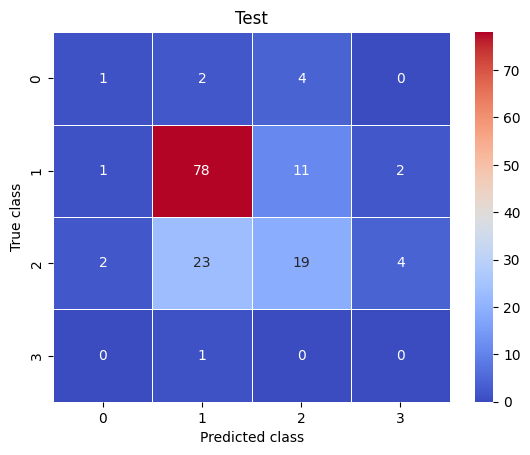

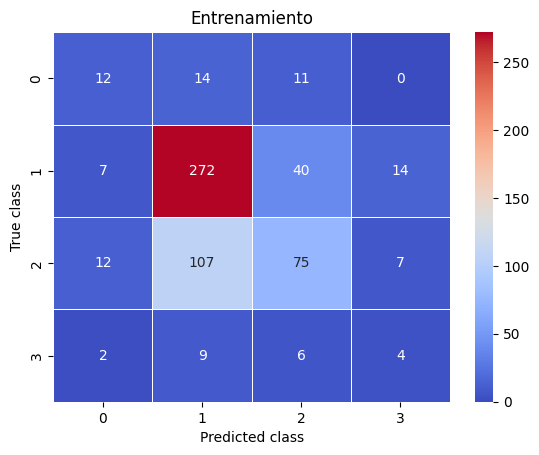

In [40]:
print(f"Casos de test: {y_test.size}")
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
print(conf_matrix.sum(axis=0))
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.title("Test")
plt.xlabel("Predicted class")
plt.ylabel("True class")

print(f"Casos de entrenamiento: {y_train.size}")
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
print(conf_matrix.sum(axis=0))
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.title("Entrenamiento")
plt.xlabel("Predicted class")
plt.ylabel("True class");